# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:    
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.    
    
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## План выполнения проекта

1. Проведите исследовательский анализ набора фотографий;
2. Подготовьте данные к обучению;
3. Обучите нейронную сеть и рассчитайте её качество.

## Описание данных

Данные содержатся в файле `/datasets/faces/labels.csv`.    
* `file_name` - наименование файла изображения;
* `real_age` - реальный возраст(целевой признак).

## Исследовательский анализ данных

### Импорты модулей и общие функции

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from tensorflow.keras.layers import Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
def view_and_get_data(path, sep=None, decimal=","):
    """
    Открывает файл, выводит первые 10 строк,
    основную информцию о дата фрейме и возвращает датафрейм.
    Принимает разделить в csv файле и разделитель десятичных чисел(по умолчанию запятая).
    """
    try:
        # Пробуем открыть файл локально, если нет, то через сервер яндекса.
        data = pd.read_csv(path, sep=sep, decimal=decimal, engine='python')
    except Exception:
        print('Локальный файл не найден. Пробую открыть серверную версию файла.')
        data = pd.read_csv(f'https://code.s3.yandex.net{path}', sep=sep, decimal=decimal)
        
    display(data.head(10))
    data.info()
    return data

In [3]:
df = view_and_get_data('/datasets/faces/labels.csv')
print('Размер датасета:', df.shape)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
Размер датасета: (7591, 2)


Фрейм содержит 7591 строк и два столбца, в одном наименование изображения, во втором реальный возраст(целевой признак). Пропусков нет.

In [4]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Минимальное значение значение возраста это один год, максимальное значение 100 лет. Вполне правдоподно, явных выбросов и аномалий нет. Основную часть данных составляет диапазон возрастов от 20 до 41 года, что вполне логично и объяснимо.

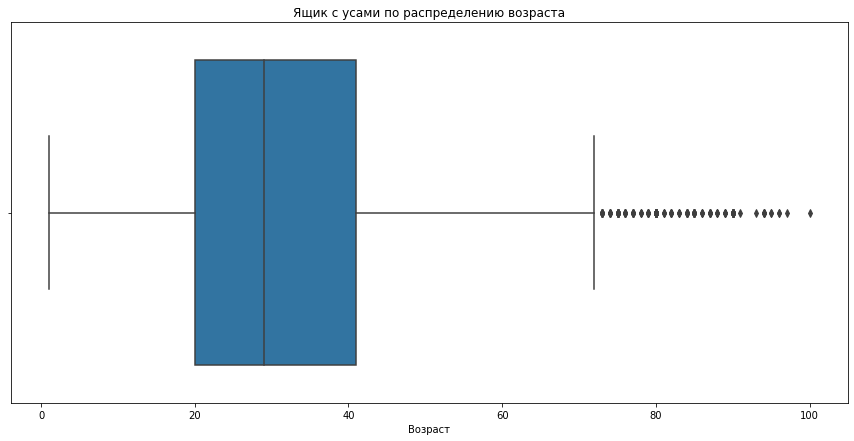

In [5]:
plt.figure(figsize=[15, 7])
sns.boxplot(x=df['real_age'])
plt.xlabel('Возраст')
plt.title('Ящик с усами по распределению возраста');

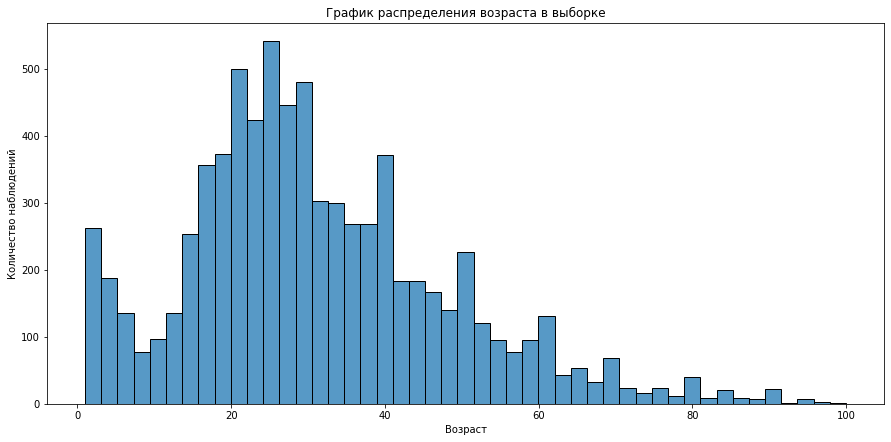

In [6]:
plt.figure(figsize=[15, 7])
sns.histplot(data=df, x='real_age')
plt.xlabel('Возраст')
plt.ylabel('Количество наблюдений')
plt.title('График распределения возраста в выборке');

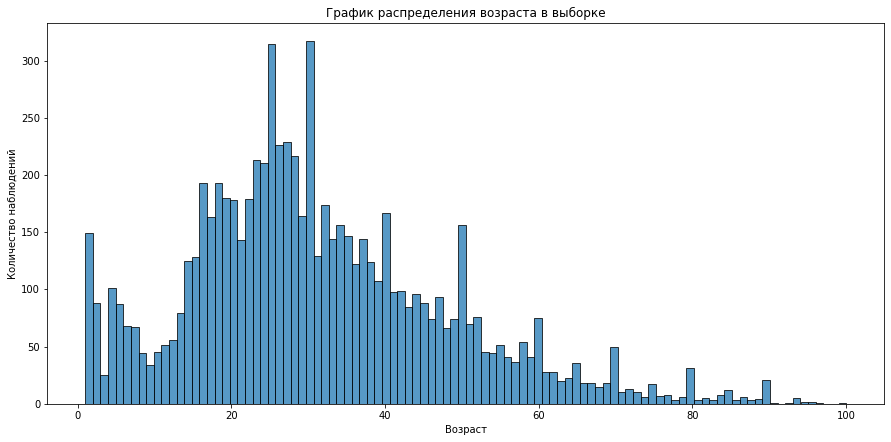

In [7]:
plt.figure(figsize=[15, 7])
sns.histplot(data=df, x='real_age', bins=100)
plt.xlabel('Возраст')
plt.ylabel('Количество наблюдений')
plt.title('График распределения возраста в выборке');

**Вывод:**    
Минимальное значение значение возраста это один год, максимальное значение 100 лет. Вполне правдоподно, явных выбросов и аномалий нет. Основную часть данных составляет диапазон возрастов от 20 до 41 года, что вполне логично и объяснимо. Это видно как на графиках, так и по данным.

Далее мы должны открыть изображения, но мне не понятен размер исходного. Большие это изображения или нет. Да и при использовании метода `flow_from_dataframe` необходимо указать размер, что вводит меня в некоторый ступор в плане понимания работы. Размер изображения изменится по тем параметрам, что я задам или что. Поэтому хотя бы просто узнаю размер одного изображения из папки.

In [8]:
im1 = Image.open('/datasets/faces/final_files/000000.jpg')
width1, height1 = im1.size
print('Ширина:', width1, 'Высота:', height1)
im2 = Image.open('/datasets/faces/final_files/000001.jpg')
width2, height2 = im2.size
print('Ширина:', width2, 'Высота:', height2)

Ширина: 114 Высота: 114
Ширина: 784 Высота: 784


In [13]:
%%time
datagen = ImageDataGenerator(
    rescale=1./255
    )
datagen_flow = datagen.flow_from_dataframe(
    dataframe=df,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)
features, target = next(datagen_flow)

#Found 7591 validated image filenames.
#CPU times: user 536 ms, sys: 366 ms, total: 902 ms
#Wall time: 1min 30s

Found 7591 validated image filenames.
CPU times: user 380 ms, sys: 189 ms, total: 569 ms
Wall time: 1min 27s


In [10]:
print('Размер выборки:', features.shape)

Размер выборки: (32, 224, 224, 3)


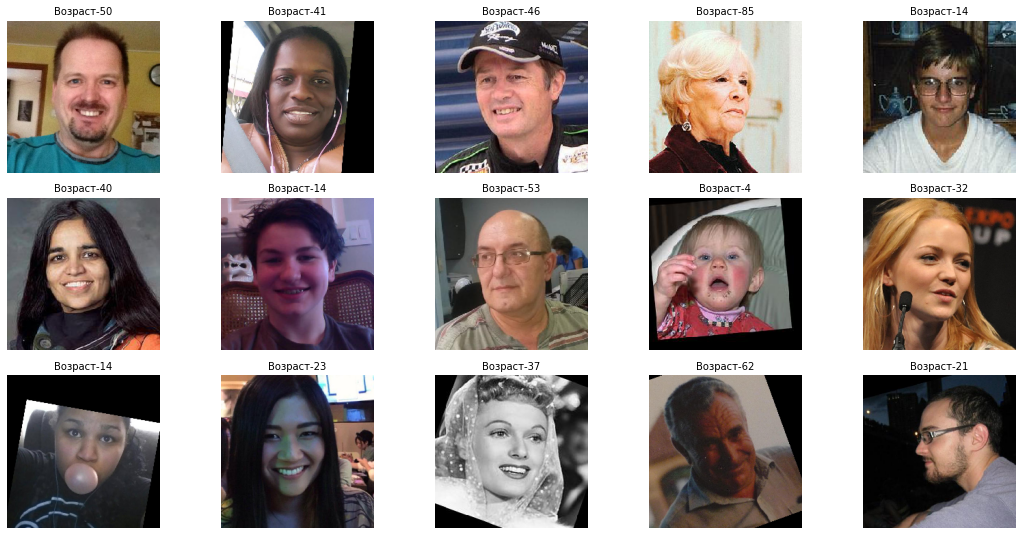

In [14]:
fig = plt.figure(figsize=(15,10))

for i in range(15):
    fig.add_subplot(4,5, i+1).axis("off")
    plt.title(f'Возраст-{target[i]}', fontsize=10)
    plt.imshow(features[i])
    plt.ylabel('Высота', fontsize=9)
    plt.xlabel('Ширина', fontsize=9)
plt.tight_layout()

**Вывод:**    
* В данных неравномерное количество фотографий для разных возрастов;
* Некоторые изображения немного повернуты в исходниках;
* Изображения людей в анфас, в профиль;
* Изображения как цветные, так и черно-белые;
* Некоторые изображения неравномерны по яркости и тону;
* В целом именно ориентация стандартная и повороты не потребовались;
* Все фото приведены к одному разрешению(масштабу).

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import numpy as np
 
def load_train(path):
    """Загружает обучающий датафрейм, предобрабатывает изображения."""
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255.,
                                       validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age', 
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_datagen_flow
 
def load_test(path):
    """Загружает тестовый датафрейм, предобрабатывает изображения."""
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255.,
                                       validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_datagen_flow
 
def create_model(input_shape):
    """Создает модель и несколько слоёв в ней с указанием требуемой метрики."""
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
 
    model.compile(loss='mae', optimizer=optimizer,
                  metrics=['mae'])
    return model
 
def train_model(model, train_data, test_data, epochs=5,
                batch_size=None, steps_per_epoch=None,
                validation_steps=None):
    """Обучает модель и возвращает её."""
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
 
    if validation_steps is None:
        validation_steps = len(test_data) 
 
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs, 
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)
    return model

```

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Написаны функции для создания датагенераторов, а также создания и обучения модели. 
</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Советую использовать аугментацию для обучающего набора, хотя бы отражение по горизонтали.

</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
В качестве лосс-функции ты используешь mae, это допустимо, но для задач регрессии более подходящей лосс-функцией является mse, с ней модели учатся быстрее и стабильнее. А mae лучше оставить в качестве метрики, которую ты дополнительно мониторишь.

</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>    
    
Точно, аугментации, чтобы модель более корректно предсказывала на тестовой выборке и в целом лучше воспринимала новые данные. Добавил отражение по горизонтали.    
    
Спасибо за уточнение по метрикам. Честно говоря я так и хотел, но про один момент вспомнил, потом про второй и упустил это из виду. Нужно в следующий раз себе отдельно помечать "план доработок", чтобы ничего не забыть)    
    
Действительно, масло маслянное. Да и так функция будет более гибкой, мало ли я захочу сменить размер, тогда не придется в нескольких местах это править. Спасибо!    
    
Для твоего удобства я размещу ниже поправленный код и шаги для него, всё же мы внесли некоторые изменения и теперь как необходимое количество эпох, так и в целом метрики будут несколько другими.
</div>

```

Train for 178 steps, validate for 60 steps
Epoch 1/5
178/178 - 64s - loss: 10.8562 - mae: 10.8552 - val_loss: 20.4736 - val_mae: 20.4680
Epoch 2/5
178/178 - 39s - loss: 6.7420 - mae: 6.7424 - val_loss: 19.9438 - val_mae: 19.9245
Epoch 3/5
178/178 - 39s - loss: 5.4920 - mae: 5.4920 - val_loss: 12.6530 - val_mae: 12.6256
Epoch 4/5
178/178 - 39s - loss: 4.8058 - mae: 4.8066 - val_loss: 9.5111 - val_mae: 9.5025
Epoch 5/5
178/178 - 39s - loss: 4.2969 - mae: 4.2964 - val_loss: 6.7522 - val_mae: 6.7600

60/60 - 10s - loss: 6.7522 - mae: 6.7600
Test MAE: 6.7600

```

```python
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import numpy as np
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255.,
                                       horizontal_flip=True,
                                       validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age', 
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_datagen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255.,
                                       validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_datagen_flow
 
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
 
    model.compile(loss='mean_squared_error', optimizer=optimizer,
                  metrics=['mae', 'mean_squared_error'])
    return model
 
def train_model(model, train_data, test_data, epochs=5,
                batch_size=None, steps_per_epoch=None,
                validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
 
    if validation_steps is None:
        validation_steps = len(test_data) 
 
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs, 
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)
    return model

```

```
Train for 178 steps, validate for 60 steps
Epoch 1/5
178/178 - 46s - loss: 247.4212 - mae: 11.3365 - mean_squared_error: 247.4727 - val_loss: 925.0566 - val_mae: 25.6026 - val_mean_squared_error: 924.7497
Epoch 2/5
178/178 - 39s - loss: 77.9216 - mae: 6.6488 - mean_squared_error: 77.9302 - val_loss: 842.1895 - val_mae: 24.0893 - val_mean_squared_error: 841.4026
Epoch 3/5
178/178 - 39s - loss: 51.4897 - mae: 5.4342 - mean_squared_error: 51.5011 - val_loss: 359.2106 - val_mae: 14.0685 - val_mean_squared_error: 357.7873
Epoch 4/5
178/178 - 39s - loss: 35.9908 - mae: 4.5707 - mean_squared_error: 35.9963 - val_loss: 193.3044 - val_mae: 10.8265 - val_mean_squared_error: 192.1108
Epoch 5/5
178/178 - 38s - loss: 27.7303 - mae: 4.0308 - mean_squared_error: 27.7340 - val_loss: 97.5827 - val_mae: 7.6856 - val_mean_squared_error: 97.3996
60/60 - 10s - loss: 97.5827 - mae: 7.6856 - mean_squared_error: 97.3996
```

## Анализ обученной модели

**Выводы:**    
* Получена модель с тербуемой метрикой ниже 8 МАЕ;
* Использована архитектура ResNet50 с предобученной моделью на стандартном датасете без включения верхушки;
* Обучения на 5-ти эпохах хватило для получения метрики требуемого качества, что говорит о том, что модель готова к применению;
* Дополнительных действий с изображением помимо приведения к общему размеру не потребовалось(повороты, осветление и прочее), без этих дополнительных действия модель справилась с задачей.